In [1]:
import typing
import torch
import numpy as np
import pandas as pd

from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader
from torch import nn


class WaveformDataset(Dataset):
    """Store the samples and their corresponding labels

    """
    def __init__(self, positions: np.ndarray, waveforms: np.ndarray):
        """Constructor

        Args:
            positions (np.ndarray): numpy array of shape [num_samples, 2]
            waveforms (np.ndarray): numpy array of shape [num_samples, num_features]
        """
        self.positions = torch.from_numpy(positions)
        self.waveforms = torch.from_numpy(waveforms)

    def __len__(self) -> int:
        return len(self.positions)

    def __getitem__(self, idx: int) -> tuple:
        position = self.positions[idx]
        waveform = self.waveforms[idx]
        return waveform, position


/home/fredericmarcotte/Code/PHS3910/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mat_dict = loadmat('Data/results.mat')
positions = mat_dict['positions'].astype('float32')
waveforms = mat_dict['waveforms']

N_SAMPLES, N_FEATURES = waveforms.shape

# shuffle the data
permuted = np.random.permutation(len(positions))
positions = positions[permuted]
waveforms = waveforms[permuted]

# training / validation / test split
n_train_samples = int(0.8 * N_SAMPLES) # 80% of dataset
n_val_samples = int(0.1 * N_SAMPLES) # 10% of dataset
n_test_samples = int(0.1 * N_SAMPLES) # 10% of dataset

train_positions = positions[:n_train_samples]
train_waveforms = waveforms[:n_train_samples]

val_positions = positions[n_train_samples:n_train_samples+n_val_samples]
val_waveforms = waveforms[n_train_samples:n_train_samples+n_val_samples]

test_positions = positions[-n_test_samples:]
test_waveforms = waveforms[-n_test_samples:]

# Dataset store the samples and their corresponding labels
training_data = WaveformDataset(train_positions, train_waveforms)
val_data = WaveformDataset(val_positions, val_waveforms)
test_data = WaveformDataset(test_positions, test_waveforms)


In [3]:
class Conv1dRegressionModel(nn.Module):
    def __init__(self, num_kernels: int, kernel_size: int, num_features: int) -> None:
        """Conv1d Regression Model

        Args:
            num_kernels (int): number of kernels in the convolution layer
            kernel_size (int): kernel size in one dimension
            num_features (int): number of features in the waveform
        """
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=num_kernels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(num_kernels * (num_features - kernel_size + 1), 2)

    def forward(self, waveforms: torch.Tensor) -> torch.Tensor:
        """Forward pass

        Args:
            waveforms (torch.Tensor): torch tensor of shape [batch_size, num_features]

        Returns:
            torch.Tensor: torch tensor of shape [batch_size, 2]
        """
        batch_size, num_features = waveforms.shape
        x = torch.reshape(waveforms, (batch_size, 1, num_features)) # (N, C_in, L_in)
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.flatten(x)
        outputs = self.linear(x)
        return outputs


class RNNRegressionModel(nn.Module):
    def __init__(self, hidden_size: int) -> None:
        """RNN Regression model

        Args:
            hidden_size (int): size of the hidden state h
        """
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = nn.Linear(hidden_size, 2)

    def forward(self, waveforms: torch.Tensor) -> torch.Tensor:
        """Forward pass

        Args:
            waveforms (torch.Tensor): torch tensor of shape [batch_size, num_features]

        Returns:
            torch.Tensor: torch tensor of shape [batch_size, 2]
        """
        batch_size, num_features = waveforms.shape
        x = torch.reshape(waveforms, (batch_size, num_features, 1)) # (N, L, H_in)
        x, _ = self.rnn(x)
        x = x[:,-1,:] # output features h_t for last t
        outputs = self.linear(x)
        return outputs


In [4]:
def validation(val_dataloader: DataLoader, model: nn.Module, loss_fn: nn.MSELoss) -> float:
    """Validation loop

    Args:
        val_dataloader (DataLoader)
        model (nn.Module)
        loss_fn (nn.MSELoss)

    Returns:
        float: val loss
    """
    num_batches = len(val_dataloader)
    val_loss = 0.

    with torch.no_grad():
        for waveforms, positions in val_dataloader:
            outputs = model(waveforms)
            val_loss += loss_fn(outputs, positions).item()
    
    val_loss /= num_batches
    print(f"Validation loss: {val_loss:>8f} \n")
    return val_loss


def epoch(train_dataloader: DataLoader, val_dataloader: DataLoader, 
            model: nn.Module, loss_fn: nn.MSELoss, optimizer: torch.optim.Adam,
            val_every_x_step: int) -> tuple:
    """Train one epoch

    Args:
        train_dataloader (DataLoader)
        val_dataloader (DataLoader)
        model (nn.Module)
        loss_fn (nn.MSELoss)
        optimizer (torch.optim.Adam)
        val_every_x_step (int)

    Returns:
        tuple
    """
    epoch_train_losses = []
    epoch_train_steps = []
    epoch_val_losses = []
    epoch_val_steps = []

    size = len(train_dataloader.dataset)

    for step, (waveforms, positions) in enumerate(train_dataloader):

        # forward pass
        outputs = model(waveforms)
        loss = loss_fn(outputs, positions)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()

        epoch_train_losses.append(loss)
        epoch_train_steps.append(step)

        if step % 100 == 0:
            current = step * len(waveforms)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        if step % val_every_x_step == 0 or step == 0:

            # forward pass
            val_loss = validation(val_dataloader, model, loss_fn)
        
            epoch_val_losses.append(val_loss)
            epoch_val_steps.append(step)
    
    return epoch_train_losses, epoch_train_steps, epoch_val_losses, epoch_val_steps


def train(num_epochs: int, train_dataloader: DataLoader, val_dataloader: DataLoader, 
            model: nn.Module, loss_fn: nn.MSELoss, optimizer: torch.optim.Adam,
            val_every_x_step: int) -> tuple:
    """Train loop

    Args:
        num_epochs (int)
        train_dataloader (DataLoader)
        val_dataloader (DataLoader)
        model (nn.Module)
        loss_fn (nn.MSELoss)
        optimizer (torch.optim.Adam)
        val_every_x_step (int)

    Returns:
        tuple
    """
    train_losses = []
    train_steps = []
    val_losses = []
    val_steps = []
    epoch_last_step = 0

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        epoch_train_losses, epoch_train_steps, \
            epoch_val_losses, epoch_val_steps = \
                epoch(train_dataloader, val_dataloader, model, loss_fn, optimizer,
                        val_every_x_step)
        
        train_losses += epoch_train_losses
        train_steps += [step + epoch_last_step for step in epoch_train_steps]

        val_losses += epoch_val_losses
        val_steps += [step + epoch_last_step for step in epoch_val_steps]

        epoch_last_step = train_steps[-1]

    return train_losses, train_steps, val_losses, val_steps


In [ ]:
MODEL = 'Conv1d'

# Conv1d hyperparameters
N_KERNELS = 10
KERNEL_SIZE = 16

# RNN hyperparameters
HIDDEN_SIZE = 16

# training hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
N_EPOCHS = 100


# DataLoader wraps an iterable around the Dataset
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)


if MODEL == 'Conv1d':
    model = Conv1dRegressionModel(N_KERNELS, KERNEL_SIZE, N_FEATURES).to('cpu')
    STATE = f'{N_KERNELS}_{KERNEL_SIZE}'
elif MODEL == 'RNN':
    model = RNNRegressionModel(HIDDEN_SIZE).to('cpu')
    STATE = f'{HIDDEN_SIZE}'
else:
    raise ValueError(f'No model {MODEL}')


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


# train model
train_losses, train_steps, val_losses, val_steps = \
    train(N_EPOCHS, train_dataloader, val_dataloader, model, loss_fn, optimizer, 1000)
val_loss = val_losses[-1]


# save model weights
torch.save(model.state_dict(), f'storage/{MODEL}_{STATE}_bs{BATCH_SIZE}_lr{LEARNING_RATE}_ep{N_EPOCHS}.pth')


# save stats
stats = pd.DataFrame(
    {   
        'train_steps': pd.Series(train_steps),
        'train_losses': pd.Series(train_losses),
        'test_steps': pd.Series(val_steps),
        'test_losses': pd.Series(val_losses)
    }
)
stats.to_pickle(f'storage/{MODEL}_{STATE}_bs{BATCH_SIZE}_lr{LEARNING_RATE}_ep{N_EPOCHS}_tl{val_loss:.8f}.pkl')


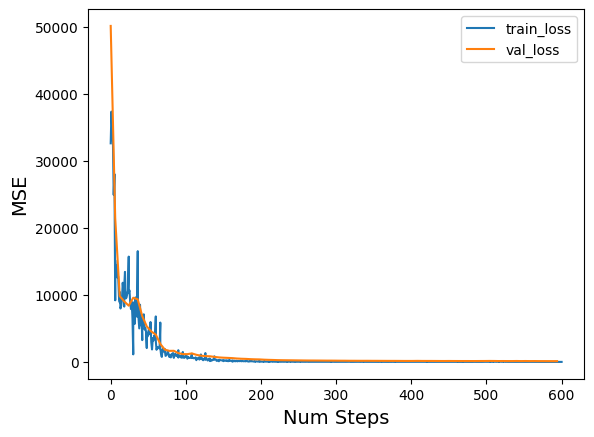

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_steps, train_losses, label='train_loss')
plt.plot(val_steps, val_losses, label='val_loss')
plt.xlabel("Num Steps", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.legend()
plt.show()

In [7]:
# test model
outputs = model(test_data.waveforms)
rmse = np.sqrt(loss_fn(outputs, test_data.positions).item())


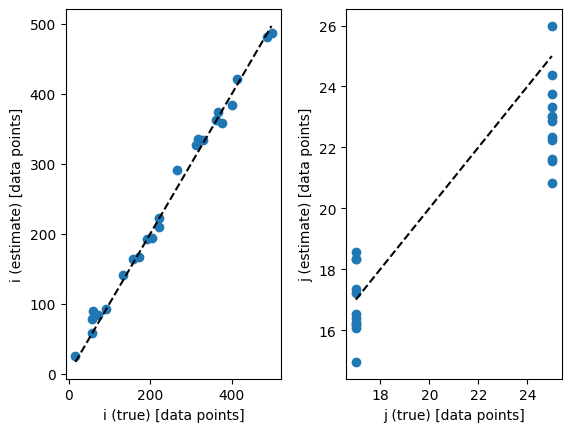

In [14]:
estimate_positions = outputs.detach().numpy()
true_positions = test_data.positions.detach().numpy()


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace':.3})

i_min = np.min(true_positions[:,0])
i_max = np.max(true_positions[:,0])
ax1.scatter(true_positions[:,0], estimate_positions[:,0])
ax1.plot([i_min, i_max], [i_min, i_max], 'k--')
ax1.set_xlabel('i (true) [data points]')
ax1.set_ylabel('i (estimate) [data points]')

j_min = np.min(true_positions[:,1])
j_max = np.max(true_positions[:,1])
ax2.scatter(true_positions[:,1], estimate_positions[:,1])
ax2.plot([j_min, j_max], [j_min, j_max], 'k--')
ax2.set_xlabel('j (true) [data points]')
ax2.set_ylabel('j (estimate) [data points]')

plt.show()


tensor([205.,  17.])


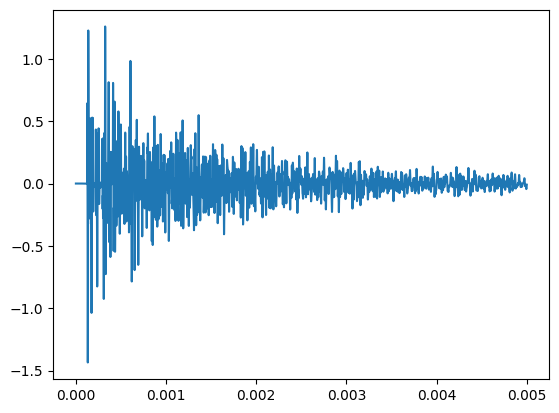

In [22]:
fig, ax = plt.subplots()

dt = 1/(100*44100)
t = np.arange(0, 0.005, dt)
k = 0
print(test_data.positions[k])
ax.plot(t, test_data.waveforms[k,:-1])
plt.show()
